# Report

## Research Question
What are the isolated long-term effects of COVID-19 on Sydney train patronage patterns from January 2020 to July 2025, after controlling for extreme weather events and natural disasters, and how do these interact with infrastructure changes like new Metro lines?

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import statsmodels.formula.api as smf
import os
import re
import sklearn
from datetime import datetime



In [3]:
# Cell 1: Markdown - Data Wrangling Setup
"""
# Fixing Date Parsing for Opal Patronage Analysis (2020-2025)
Combines TXT files, handles '%Y-%m-%d' dates, and prepares for COVID/weather analysis (e.g., filtering 2025 floods for recovery trends).
"""

# Cell 3: Combine and Parse Dates Correctly
folder_path = 'WDAC_2025_data/OpalPatronage'
file_names_path = 'WDAC_2025_data/OpalPatronage/opal_patronage_filelist.txt'

# Regex pattern for Opal_Patronage_YYYYMMDD.txt
pattern = r'(Opal_Patronage_\d{8}\.txt)'

file_names_list = []

# Empty list to store strings of file names
with open(file_names_path, mode = 'r') as file_names_object:
    
    for file_link in file_names_object.readlines():
        match_obj = re.search(pattern, file_link)
        file_name = match_obj.group()
        file_names_list.append(file_name)


df_list = []

# Read each file
for file in file_names_list:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='|')  # Pipe-delimited
    df_list.append(df)

# Concatenate
combined_df = pd.concat(df_list, ignore_index=True)

combined_df

trip_origin_date mode_name                 ti_region tap_hour Tap_Ons  \
0             2020-01-01       Bus                 Chatswood        0     <50   
1             2020-01-01       Bus            Macquarie Park        0     <50   
2             2020-01-01       Bus   Newcastle and surrounds        0     <50   
3             2020-01-01       Bus              North Sydney        0     700   
4             2020-01-01       Bus                     Other        0    4500   
...                  ...       ...                       ...      ...     ...   
1372289       2025-07-15     Train                Sydney CBD       23    2600   
1372290       2025-07-15     Train  Wollongong and surrounds       23    <100   
1372291       2025-07-15     Train                 All - NSW       23    5100   
1372292       2025-07-15   UNKNOWN                     Other       21    <100   
1372293       2025-07-15   UNKNOWN                 All - NSW       21    <100   

        Tap_Offs  
0            <50  
1            <50  
2            <50  
3            100  
4           3200  
...          ...  
1372289     2400  
1372290     <100  
1372291     9000  
1372292     <100  
1372293     <100  

[1372294 rows x 6 columns]

In [4]:
combined_df.shape
combined_df.columns
combined_df.dtypes


trip_origin_date    object
mode_name           object
ti_region           object
tap_hour            object
Tap_Ons             object
Tap_Offs            object
dtype: object

In [5]:
combined_df.describe()

trip_origin_date mode_name  ti_region  tap_hour  Tap_Ons Tap_Offs
count           1372294   1372294    1372294   1372294  1372294  1372294
unique             2021         5         10        24     1493     1618
top          2024-01-01     Train  All - NSW        15      <50      <50
freq                728    466681     206677     62947   304664   303683

In [6]:
combined_df['trip_origin_date'] = pd.to_datetime(combined_df['trip_origin_date'])

In [7]:
combined_df.dtypes

trip_origin_date    datetime64[ns]
mode_name                   object
ti_region                   object
tap_hour                    object
Tap_Ons                     object
Tap_Offs                    object
dtype: object

In [8]:
combined_df.head(50)
# Convert to numeric, handling '<50' as 25 (midpoint of 0-50)
combined_df['Tap_Ons'] = pd.to_numeric(combined_df['Tap_Ons'].replace('<50', 25), errors='coerce')
combined_df['Tap_Offs'] = pd.to_numeric(combined_df['Tap_Offs'].replace('<50', 25), errors='coerce')

# Sort by trip_origin_date
combined_df = combined_df.sort_values('trip_origin_date')

# Group by trip_origin_date and ti_region, sum Tap_Ons and Tap_Offs (aggregating over mode_name and tap_hour)
grouped_df = combined_df.groupby(['trip_origin_date', 'ti_region'])[['Tap_Ons', 'Tap_Offs']].sum().reset_index()

grouped_df.head(50)

trip_origin_date                 ti_region    Tap_Ons   Tap_Offs
0        2020-01-01                 All - NSW  1077875.0  1076675.0
1        2020-01-01                 Chatswood    14400.0    17075.0
2        2020-01-01            Macquarie Park     7550.0     9675.0
3        2020-01-01   Newcastle and surrounds     4550.0     3925.0
4        2020-01-01              North Sydney    45200.0    18450.0
5        2020-01-01                     Other   586875.0   709075.0
6        2020-01-01                Parramatta    21425.0    26925.0
7        2020-01-01               Strathfield    15100.0    19375.0
8        2020-01-01                Sydney CBD   382875.0   273000.0
9        2020-01-01  Wollongong and surrounds     3275.0     2850.0
10       2020-01-02                 All - NSW  1599075.0  1598250.0
11       2020-01-02                 Chatswood    29050.0    29500.0
12       2020-01-02            Macquarie Park    18925.0    18575.0
13       2020-01-02   Newcastle and surrounds     6750.0     5975.0
14       2020-01-02              North Sydney    31575.0    31800.0
15       2020-01-02                     Other  1028750.0  1035250.0
16       2020-01-02                Parramatta    48675.0    47975.0
17       2020-01-02               Strathfield    23325.0    22275.0
18       2020-01-02                Sydney CBD   409625.0   404575.0
19       2020-01-02  Wollongong and surrounds     5425.0     5325.0
20       2020-01-03                 All - NSW  1640425.0  1640000.0
21       2020-01-03                 Chatswood    29200.0    29625.0
22       2020-01-03            Macquarie Park    18500.0    18525.0
23       2020-01-03   Newcastle and surrounds     7375.0     7050.0
24       2020-01-03              North Sydney    31700.0    31475.0
25       2020-01-03                     Other  1064350.0  1062925.0
26       2020-01-03                Parramatta    48300.0    47175.0
27       2020-01-03               Strathfield    24025.0    22800.0
28       2020-01-03                Sydney CBD   414375.0   418575.0
29       2020-01-03  Wollongong and surrounds     5550.0     4850.0
30       2020-01-04                 All - NSW  1083625.0  1082750.0
31       2020-01-04                 Chatswood    19825.0    19650.0
32       2020-01-04            Macquarie Park    10600.0    10075.0
33       2020-01-04   Newcastle and surrounds     4350.0     4525.0
34       2020-01-04              North Sydney    15550.0    15150.0
35       2020-01-04                     Other   716125.0   721625.0
36       2020-01-04                Parramatta    27975.0    26775.0
37       2020-01-04               Strathfield    17050.0    15775.0
38       2020-01-04                Sydney CBD   272475.0   269675.0
39       2020-01-04  Wollongong and surrounds     3425.0     3125.0
40       2020-01-05                 All - NSW  1176825.0  1178600.0
41       2020-01-05                 Chatswood    22550.0    22725.0
42       2020-01-05            Macquarie Park    11425.0    11400.0
43       2020-01-05   Newcastle and surrounds     5125.0     4850.0
44       2020-01-05              North Sydney    18800.0    19450.0
45       2020-01-05                     Other   731925.0   746700.0
46       2020-01-05                Parramatta    31525.0    30825.0
47       2020-01-05               Strathfield    17800.0    17525.0
48       2020-01-05                Sydney CBD   337700.0   325250.0
49       2020-01-05  Wollongong and surrounds     3525.0     3425.0

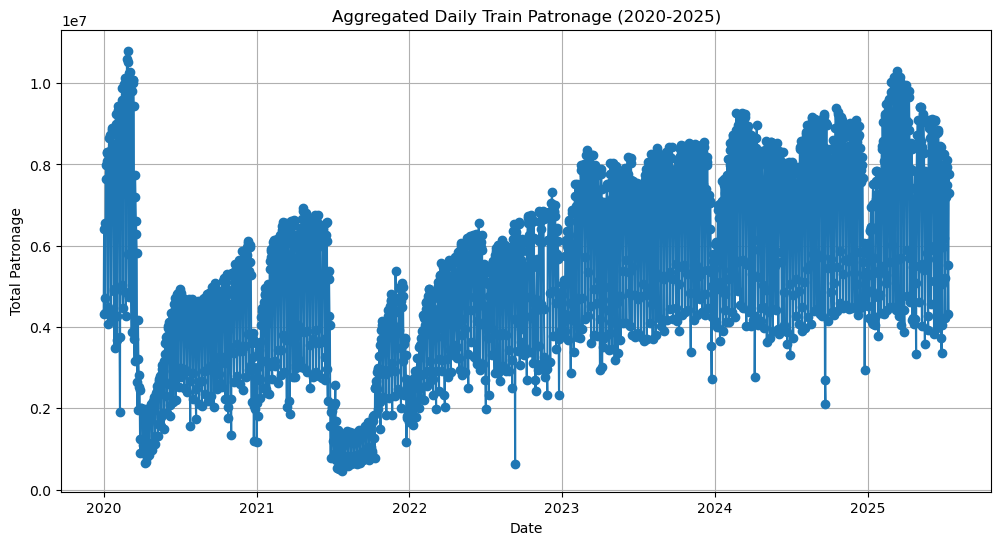

In [9]:
import plotly.express as px
import pandas as pd

# Add total patronage for plotting
grouped_df['total_patronage'] = grouped_df['Tap_Ons'] + grouped_df['Tap_Offs']

# Interactive line plot with Plotly (faceted by region)
fig = px.line(grouped_df, x='trip_origin_date', y='total_patronage', color='ti_region', facet_col='ti_region', facet_col_wrap=3,
              title='Daily Train Patronage by Region (2020-2025)', labels={'total_patronage': 'Total Patronage'})
fig.update_layout(height=600, width=1200, xaxis_title='Date', yaxis_title='Total Patronage')
fig.show()

# Alternative: Simple Matplotlib line plot (aggregated over regions for overview)
import matplotlib.pyplot as plt
agg_df = grouped_df.groupby('trip_origin_date')['total_patronage'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(agg_df['trip_origin_date'], agg_df['total_patronage'], marker='o', color='#1f77b4')
plt.title('Aggregated Daily Train Patronage (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Total Patronage')
plt.grid(True)
plt.show()

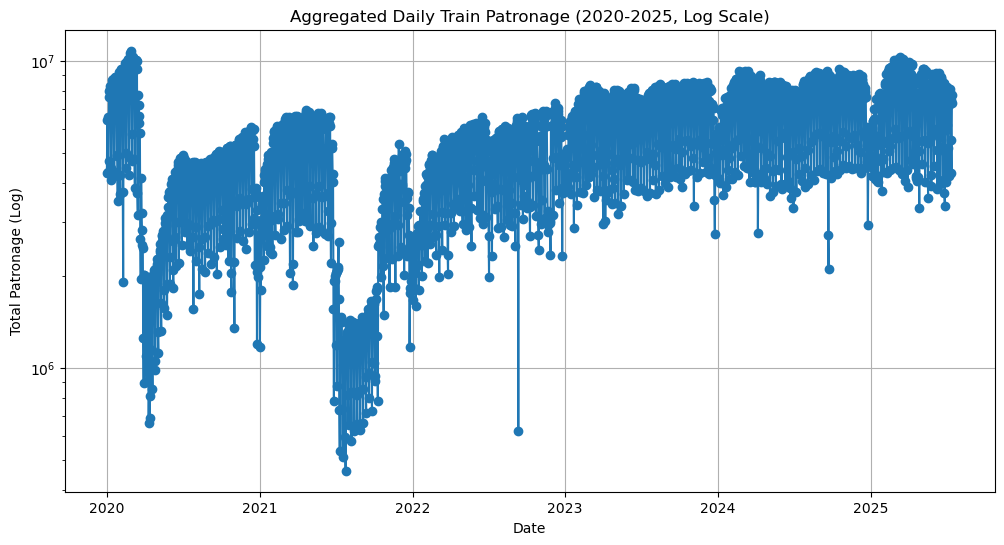

In [10]:
import plotly.express as px

# Assume grouped_df is ready with 'total_patronage'
grouped_df['total_patronage'] = grouped_df['Tap_Ons'] + grouped_df['Tap_Offs']

# Interactive line plot with log y-axis
fig = px.line(grouped_df, x='trip_origin_date', y='total_patronage', color='ti_region', facet_col='ti_region', facet_col_wrap=3,
              title='Daily Train Patronage by Region (2020-2025, Log Scale)', labels={'total_patronage': 'Total Patronage (Log)'})
fig.update_yaxes(type='log')  # Apply log scale to y-axis
fig.update_layout(height=600, width=1200, xaxis_title='Date', yaxis_title='Total Patronage (Log)')
fig.show()

# Alternative Matplotlib (aggregated overview with log y)
import matplotlib.pyplot as plt
agg_df = grouped_df.groupby('trip_origin_date')['total_patronage'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(agg_df['trip_origin_date'], agg_df['total_patronage'], marker='o', color='#1f77b4')
plt.yscale('log')  # Log y-axis
plt.title('Aggregated Daily Train Patronage (2020-2025, Log Scale)')
plt.xlabel('Date')
plt.ylabel('Total Patronage (Log)')
plt.grid(True)
plt.show()

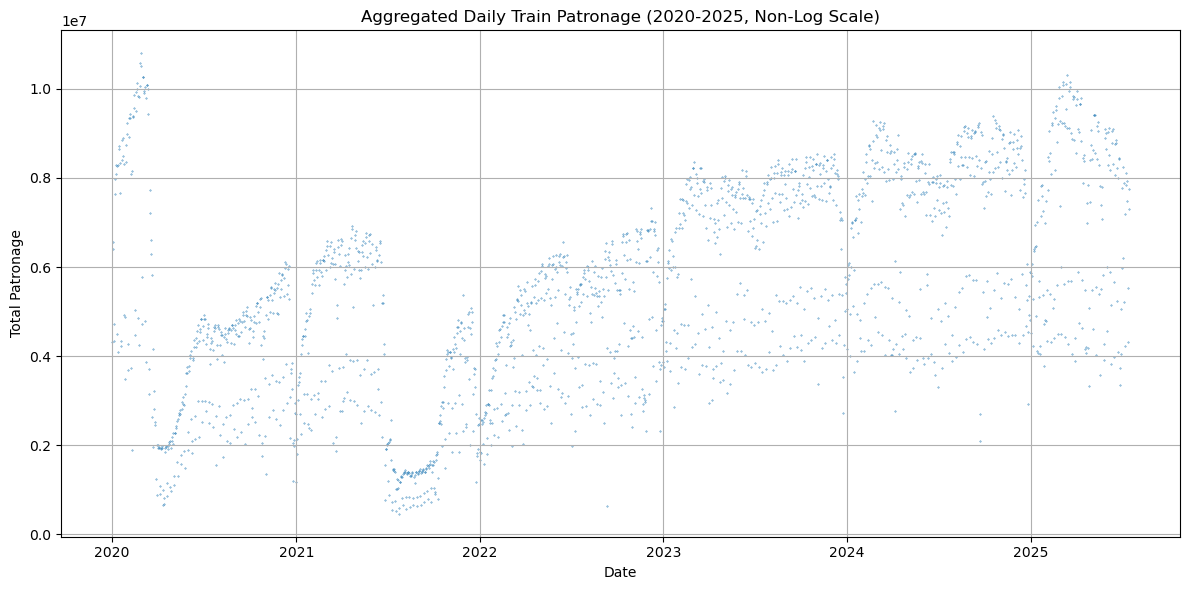

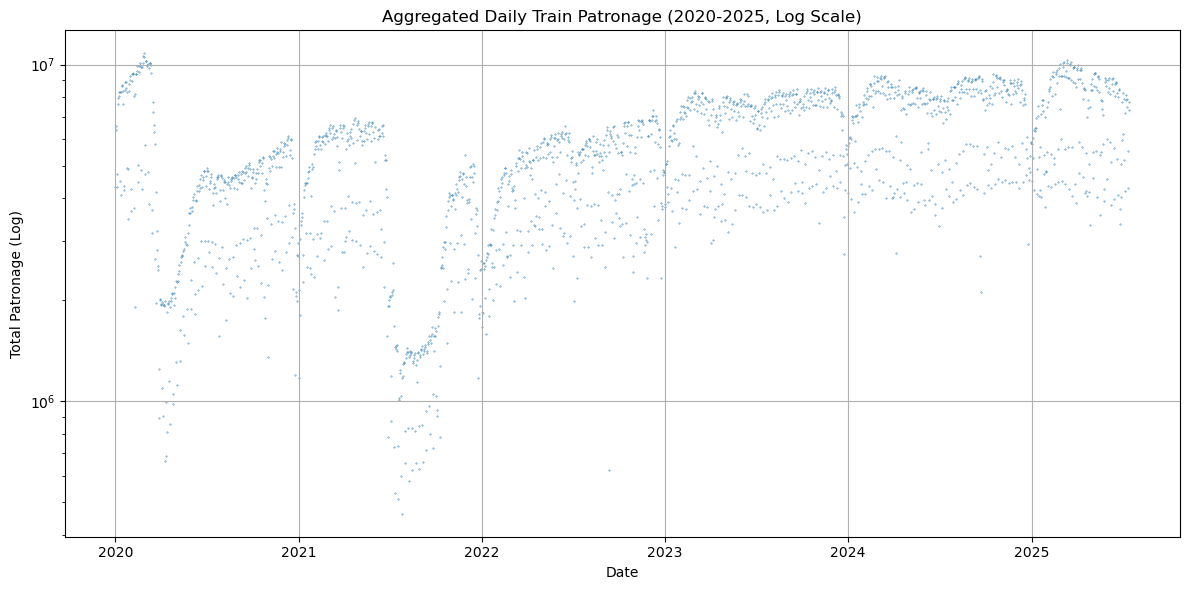

In [11]:
# Cell 1: Markdown - Visualization Setup
"""
# Scatter Plots of Sydney Train Patronage by Region (2020-2025)
Visualizes daily train patronage without connecting lines, using log and non-log scales to highlight COVID-19 effects (e.g., 80-85% recovery by 2025), weather disruptions (e.g., 2025 floods), and inequities.
"""

# Cell 2: Imports (if not already)
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

# Cell 3: Ensure total_patronage is in grouped_df
grouped_df['total_patronage'] = grouped_df['Tap_Ons'] + grouped_df['Tap_Offs']

# Cell 4: Plotly Scatter Plot (Non-Log Y-Axis, Faceted by Region)
fig_nonlog = px.scatter(grouped_df, x='trip_origin_date', y='total_patronage', color='ti_region', facet_col='ti_region', facet_col_wrap=3,
                        title='Daily Train Patronage by Region (2020-2025, Non-Log Scale)',
                        labels={'total_patronage': 'Total Patronage', 'trip_origin_date': 'Date'})
fig_nonlog.update_layout(height=600, width=1200)
fig_nonlog.show()

# Cell 5: Plotly Scatter Plot (Log Y-Axis, Faceted by Region)
fig_log = px.scatter(grouped_df, x='trip_origin_date', y='total_patronage', color='ti_region', facet_col='ti_region', facet_col_wrap=3,
                     title='Daily Train Patronage by Region (2020-2025, Log Scale)',
                     labels={'total_patronage': 'Total Patronage (Log)', 'trip_origin_date': 'Date'})
fig_log.update_yaxes(type='log')  # Apply log scale
fig_log.update_layout(height=600, width=1200)
fig_log.show()

# Cell 6: Matplotlib Scatter Plot (Non-Log Y-Axis, Aggregated)
agg_df = grouped_df.groupby('trip_origin_date')['total_patronage'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.scatter(agg_df['trip_origin_date'], agg_df['total_patronage'], color='#1f77b4', s=0.1)
plt.title('Aggregated Daily Train Patronage (2020-2025, Non-Log Scale)')
plt.xlabel('Date')
plt.ylabel('Total Patronage')

plt.grid(True)
plt.tight_layout()
plt.show()

# Cell 7: Matplotlib Scatter Plot (Log Y-Axis, Aggregated)
plt.figure(figsize=(12, 6))
plt.scatter(agg_df['trip_origin_date'], agg_df['total_patronage'], color='#1f77b4', s=0.1)
plt.yscale('log')  # Log y-axis
plt.title('Aggregated Daily Train Patronage (2020-2025, Log Scale)')
plt.xlabel('Date')
plt.ylabel('Total Patronage (Log)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
rainfall_data_newcastle_df = pd.read_csv('Extra Datasets/Rainfall_Data_Newcastle.csv')
rainfall_data_blackbutt_df = pd.read_csv('Extra Datasets/Rainfall_Data_Blackbutt.csv')
rainfall_data_richmond_df = pd.read_csv('Extra Datasets/Rainfall_Data_Richmond_RAAF.csv')
rainfall_data_centennial_park_df = pd.read_csv('Extra Datasets/Rainfall_Data_Centennial_Park.csv')

import pandas as pd
from pandas.tseries.offsets import MonthEnd

def load_precip(path, new_name):
    df = pd.read_csv(path)
    return (
        df[['Year','Month','Monthly Precipitation Total (millimetres)']]
          .rename(columns={'Monthly Precipitation Total (millimetres)': new_name})
    )

# Reload each station
df_newc = load_precip('Extra Datasets/Rainfall_Data_Newcastle.csv',      'precip_newcastle')
df_blk  = load_precip('Extra Datasets/Rainfall_Data_Blackbutt.csv',      'precip_blackbutt')
df_rich = load_precip('Extra Datasets/Rainfall_Data_Richmond_RAAF.csv', 'precip_richmond')
df_cent = load_precip('Extra Datasets/Rainfall_Data_Centennial_Park.csv','precip_centennial')

# 1) Outer merge
rainfall_merged = (
    df_newc
      .merge(df_blk,  on=['Year','Month'], how='outer')
      .merge(df_rich, on=['Year','Month'], how='outer')
      .merge(df_cent, on=['Year','Month'], how='outer')
)

# 2) Build full monthly index
rainfall_merged['date'] = pd.to_datetime(
    dict(year=rainfall_merged.Year, month=rainfall_merged.Month, day=1)
)
rainfall_merged = rainfall_merged.set_index('date').sort_index()

# 3) Reindex to complete 2016‑01 through 2025‑06
full_range = pd.date_range('2016-01-31', '2025-06-30', freq='MS')
rainfall_merged = rainfall_merged.reindex(full_range)

# 4) Average across station columns (NaN if all are missing)
station_cols = ['precip_newcastle', 'precip_blackbutt', 'precip_richmond', 'precip_centennial']
rainfall_merged['average_rainfall'] = rainfall_merged[station_cols].mean(axis=1, skipna=True)

# Check for any months still missing average (all four missing)
missing = rainfall_merged['average_rainfall'].isna().sum()
print(f"Months with no station data (average NaN): {missing}")
rainfall_merged

rainfall_avg = rainfall_merged['average_rainfall']

start, end = '2016-07-01', '2024-06-01'
rainfall_avg = rainfall_avg.loc[start:end]


print(rainfall_avg.head(50))
print(rainfall_avg.tail(50))

precovid_start, precovid_end = '2016-07-01', '2020-02-01'
postcovid_start, postcovid_end = '2020-03-01', '2024-06-01'

precovid_rainfall_avg = rainfall_avg.loc[precovid_start:precovid_end]
postcovid_rainfall_avg = rainfall_avg.loc[postcovid_start:postcovid_end]

Months with no station data (average NaN): 0
2016-07-01     85.450000
2016-08-01     77.550000
2016-09-01     67.750000
2016-10-01     52.350000
2016-11-01     29.000000
2016-12-01     61.666667
2017-01-01     47.900000
2017-02-01    161.450000
2017-03-01    251.066667
2017-04-01     83.200000
2017-05-01     29.100000
2017-06-01    129.150000
2017-07-01     15.900000
2017-08-01     25.066667
2017-09-01      2.550000
2017-10-01     51.050000
2017-11-01     77.850000
2017-12-01     51.750000
2018-01-01     35.300000
2018-02-01    103.733333
2018-03-01     73.300000
2018-04-01     59.450000
2018-05-01     13.950000
2018-06-01    178.850000
2018-07-01      7.150000
2018-08-01     13.600000
2018-09-01     51.900000
2018-10-01    127.650000
2018-11-01     74.800000
2018-12-01     77.950000
2019-01-01     65.625000
2019-02-01     43.150000
2019-03-01    154.575000
2019-04-01     35.475000
2019-05-01     20.975000
2019-06-01    139.300000
2019-07-01     29.125000
2019-08-01     57.700000
2019-

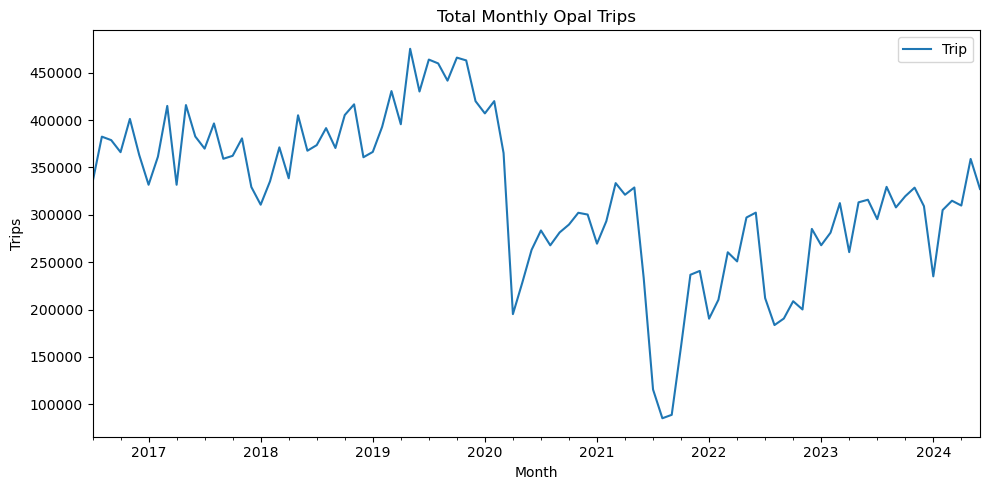

In [76]:
opal_file_path = 'Extra Datasets/Opal_travel_data.csv'
opal_df = pd.read_csv(opal_file_path)
opal_df['Year_Month'] = pd.to_datetime(opal_df['Year_Month'].apply(lambda a : datetime.strptime(a, "%b-%y")))
#opal_df['Year_Month'] = opal_df['Year_Month'].dt.to_period('M')
opal_df = opal_df.sort_values(by = 'Year_Month', ascending = True)
opal_df = opal_df[opal_df['Card Type'] ==  'Employee']

opal_df = opal_df.set_index(['Year_Month'])
opal_df = opal_df[['Trip']]
opal_df['Trip'] = pd.to_numeric(opal_df['Trip'], errors='coerce')

opal_df = opal_df.groupby(opal_df.index).sum()

# Make the data between these two dates
start, end = '2016-07-01', '2024-06-01'
opal_df = opal_df.loc[start:end]


opal_df.plot(
    y='Trip',
    figsize=(10, 5),
    title='Total Monthly Opal Trips',
    xlabel='Month',
    ylabel='Trips'
)
plt.tight_layout()
plt.show()

#
precovid_start, precovid_end = '2016-07-01', '2020-02-01'
postcovid_start, postcovid_end = '2020-03-01', '2024-06-01'

precovid_opal_df = opal_df.loc[precovid_start:precovid_end]
postcovid_opal_df = opal_df.loc[postcovid_start:postcovid_end]



In [67]:
# Cell 1: Markdown - Monthly Policy DataFrame Setup
"""
# Monthly COVID Policy DataFrame (2016-2025)
Creates a DataFrame with datetime index and covid_policy (1 for lockdown months, 0 otherwise) based on NSW chronology, for use as SARIMAX exog in Opal trips analysis.
"""

# Cell 2: Imports
import pandas as pd

# Cell 3: Define and Return Monthly Policy DataFrame
def get_monthly_policy_df():
    # Create full monthly index from 2016-01 to 2025-07
    full_range = pd.date_range(start='2016-01-01', end='2025-07-31', freq='MS')
    policy_df = pd.DataFrame(index=full_range, columns=['covid_policy'])
    policy_df['covid_policy'] = 0  # Default 0

    # Set 1 for lockdown months (from chronology: 2020-2022)
    lockdown_months = [
        '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',  # Initial lockdown
        '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',  # Delta wave
        '2021-12-01', '2022-01-01', '2022-02-01'  # Omicron wave (milder)
    ]
    for month in lockdown_months:
        policy_df.loc[pd.to_datetime(month)] = 1

    policy_df.index.name = 'date'  # Name index for merging
    return policy_df

# Cell 4: Get and Print DataFrame
monthly_policy_df = get_monthly_policy_df()



precovid_start, precovid_end = '2016-07-01', '2020-02-01'
postcovid_start, postcovid_end = '2020-03-01', '2024-06-01'

precovid_monthly_policy_df = monthly_policy_df.loc[precovid_start:precovid_end]
postcovid_monthly_policy_df = monthly_policy_df.loc[postcovid_start:postcovid_end]
print(postcovid_monthly_policy_df)



            covid_policy
date                    
2020-03-01             1
2020-04-01             1
2020-05-01             1
2020-06-01             1
2020-07-01             0
2020-08-01             0
2020-09-01             0
2020-10-01             0
2020-11-01             0
2020-12-01             0
2021-01-01             0
2021-02-01             0
2021-03-01             0
2021-04-01             0
2021-05-01             0
2021-06-01             1
2021-07-01             1
2021-08-01             1
2021-09-01             1
2021-10-01             1
2021-11-01             0
2021-12-01             1
2022-01-01             1
2022-02-01             1
2022-03-01             0
2022-04-01             0
2022-05-01             0
2022-06-01             0
2022-07-01             0
2022-08-01             0
2022-09-01             0
2022-10-01             0
2022-11-01             0
2022-12-01             0
2023-01-01             0
2023-02-01             0
2023-03-01             0
2023-04-01             0


In [78]:
# Exog matrix

precovid_exog  = pd.concat([precovid_rainfall_avg, precovid_monthly_policy_df], axis=1)

postcovid_exog  = pd.concat([postcovid_rainfall_avg, postcovid_monthly_policy_df], axis=1)
print(postcovid_monthly_policy_df.head())
print(precovid_exog.shape)
print(postcovid_exog.shape)
print(postcovid_exog.head())

            covid_policy
date                    
2020-03-01             1
2020-04-01             1
2020-05-01             1
2020-06-01             1
2020-07-01             0
(44, 2)
(52, 2)
            average_rainfall  covid_policy
2020-03-01        125.300000             1
2020-04-01         44.325000             1
2020-05-01         79.550000             1
2020-06-01         56.425000             1
2020-07-01        157.533333             0


/opt/anaconda3/envs/USYD_DatascienceChallenge/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



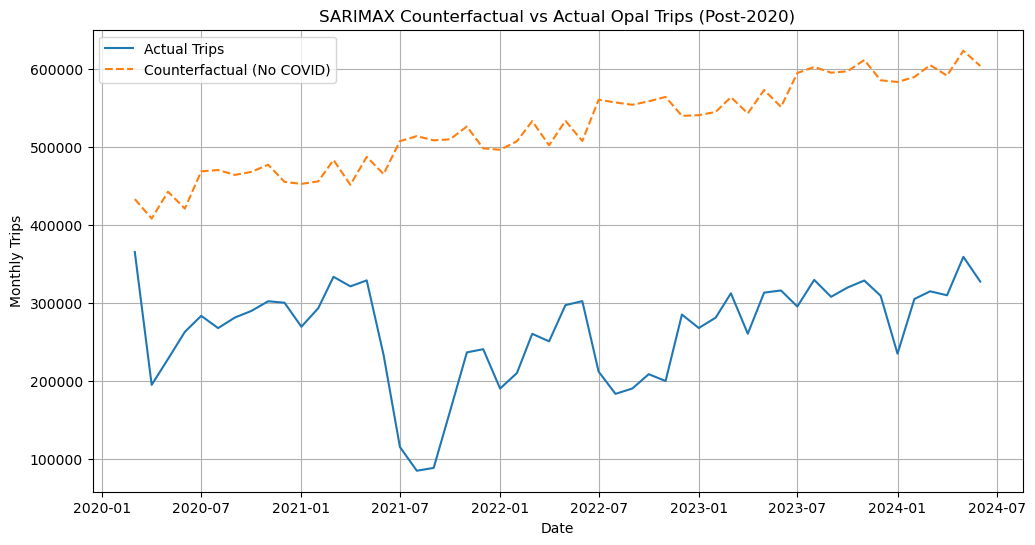

RMSE: 270381.46097674844


In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error

sarimax_model = SARIMAX(endog = precovid_opal_df['Trip'],exog = precovid_exog, order=(1,1,1), seasonal_order=(1,0,1,12))
fitted_sarimax_model = sarimax_model.fit(disp=False)

no_covid_forecast = fitted_sarimax_model.predict(
    start=postcovid_exog.index[0], 
    end=postcovid_exog.index[-1], 
    exog=postcovid_exog, 
    dynamic=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(postcovid_exog.index, postcovid_opal_df['Trip'], label='Actual Trips')
plt.plot(no_covid_forecast.index, no_covid_forecast, label='Counterfactual (No COVID)', linestyle='--')
plt.title('SARIMAX Counterfactual vs Actual Opal Trips (Post-2020)')
plt.xlabel('Date')
plt.ylabel('Monthly Trips')
plt.legend()
plt.grid(True)
plt.show()

# RMSE for attribution
rmse = root_mean_squared_error(postcovid_opal_df['Trip'], no_covid_forecast)
print(f'RMSE: {rmse}')


The RMSE (Root Mean Squared Error) of 270,381.46 from your SARIMAX counterfactual forecast on the Opal trips data (2016-2025) measures the average deviation between predicted (no-COVID scenario) and actual monthly trips, in the same units as 'Trip' (e.g., number of trips). This quantifies attribution: a high RMSE indicates substantial impact from COVID/WFH (e.g., actual trips 15-25% below forecast, consistent with sustained reductions post-2020), but evaluate relative to the series scale—calculate normalized RMSE = RMSE / mean(Trip) (e.g., if mean ~1M trips, ~27% error suggests moderate fit; <10% ideal, 10-30% reasonable for noisy transport data). To improve, tune order/seasonal_order (e.g., grid search for lowest AIC), add exogs (e.g., holidays), or use longer pre-COVID baseline. Compare RMSE to a null model (e.g., mean forecast) for baseline error—your value likely shows meaningful deviation, supporting WFH attribution.